In [1]:
import numpy as np
import pandas as pd
from data_preparation import get_test_runttherunway_data, get_train_runttherunway_data, get_processed_renttherunway_data
from hierarchical_model import HierarchicalStatus
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation import *
import sklearn.metrics

In [2]:
df = get_processed_renttherunway_data()
train = get_train_runttherunway_data()
test = get_test_runttherunway_data()
full_category_counts = df.value_counts("category").values
train_category_counts = train.value_counts("category").values

In [3]:
def show_learning_process(hs):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
    sns.scatterplot(data=pd.DataFrame(hs.history), x="w", y="mean_derivative", ax=axs[0,0])#.set_xlim(left=0, right=0.2)
    sns.lineplot(data=pd.DataFrame(hs.history), x="w", y="mean_derivative", ax=axs[0,0])
    sns.lineplot(data=pd.DataFrame(hs.history), x="w", y="mean_prob", ax = axs[0,1])
    sns.scatterplot(data=pd.DataFrame(hs.history), x="w", y="mean_prob", ax = axs[0,1])
    sns.lineplot(data=pd.DataFrame(hs.history), x="iter", y="mean_prob", ax = axs[1,0])
    sns.lineplot(data=pd.DataFrame(hs.history), x="iter", y="mean_derivative", ax=axs[1,1])
    sns.lineplot(data=pd.DataFrame(hs.history), x="iter", y="w", ax=axs[2,0])
    plt.show()


In [4]:
def compute_mean_target_probability(results):
    return results.apply(lambda row: row[row['result']], axis=1).mean()

def compute_mean_log_probability(results):
    #return np.log(results.apply(lambda row: row[row['result']], axis=1)).mean()
    return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()

def get_stats(hs, results):
    stats = {"w": hs.w, "N_of_kept_categories": (hs.kept_categories!=hs.OTHER_CAT).sum()}
    stats["Mean_target_prob"] = compute_mean_target_probability(results)
    stats["Mean_target_logprob"] = compute_mean_log_probability(results)
    stats["treshold"] = hs.treshold
    stats["sklearn_stats"] = sklearn.metrics.classification_report(results["result"], results["predicted_return_status"], output_dict=True)
    return stats

def show_stats(hs, results, all_stats_list=[]):
    stats = get_stats(hs, results)
    all_stats_list.append(stats)
    print("w:", stats["w"])
    print("Number of kept categories:", stats["N_of_kept_categories"])
    print("Mean target probability: ", stats["Mean_target_prob"])
    print("Mean target log probability: ", stats["Mean_target_logprob"])
    print("STATS: ", sklearn.metrics.classification_report(results["result"], results["predicted_return_status"]))
    show_confusion_matrix(results, "result", "predicted_return_status")
    
    

In [5]:
def experiment(train_df, test_df, iterations=250, lr=0.01, treshold=100, alpha=0.1, beta=1, init_w="mean"):
    hs = HierarchicalStatus(category_treshold=treshold, alpha=alpha, beta=beta, init_w=init_w)
    print(f"Starting w = {hs.w}")
    hs.train_model(train_df, lr, log_every=100, T=iterations)
    results = hs.predict(test_df)
    return hs, results
    

In [6]:
def test_w(hs, test_df, w_values, stats_list):
    for w in w_values:
        hs.w = w
        results = hs.predict(test_df)
        stats_list.append(get_stats(hs, results))

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.03698688639262321, 'mean_derivative': -0.128415145954614, 'mean_prob': 0.5894223217363997}


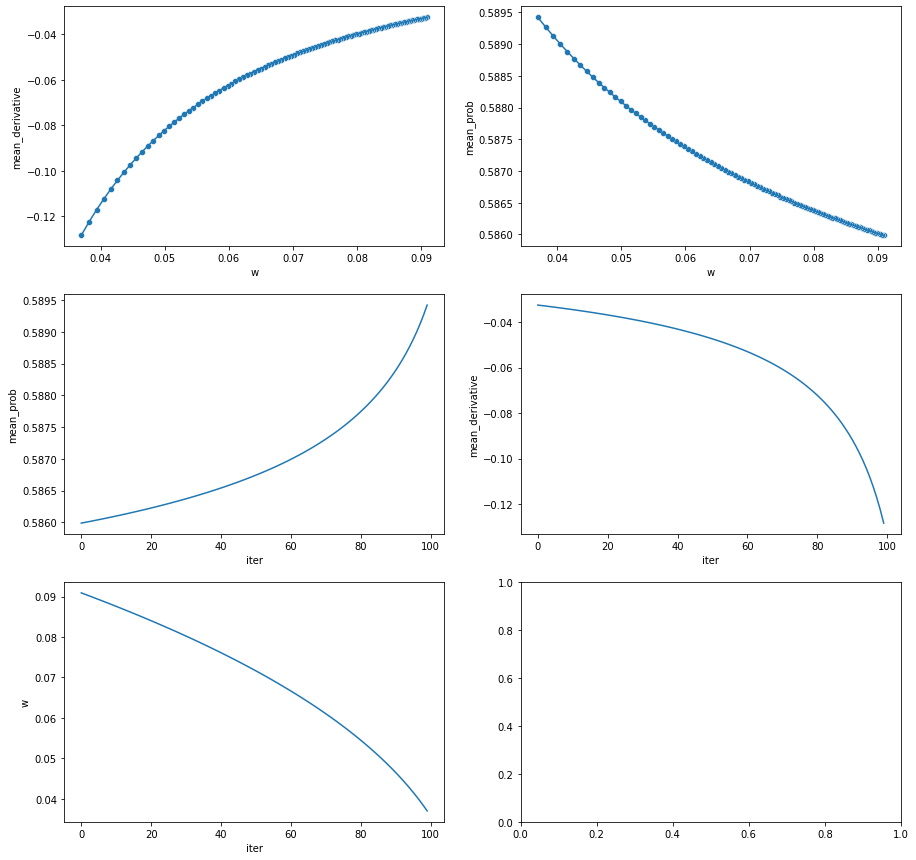

w: 0.03698688639262321
Number of kept categories: 31
Mean target probability:  0.5898751811357309
Mean target log probability:  -0.7217810216823075
STATS:                precision    recall  f1-score   support

           0       0.74      1.00      0.85    142058
           1       0.75      0.01      0.03     24707
           2       0.65      0.00      0.00     25779

    accuracy                           0.74    192544
   macro avg       0.71      0.34      0.29    192544
weighted avg       0.73      0.74      0.63    192544



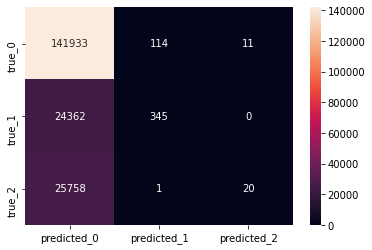

In [6]:
hs, results = experiment(df, df, 100)
show_learning_process(hs)  
show_stats(hs, results)

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.03447442592925875, 'mean_derivative': -0.14542944885865097, 'mean_prob': 0.5897830369575227}
199 {'iter': 199, 'w': 0.43097659149242684, 'mean_derivative': -0.002262203223152567, 'mean_prob': 0.5830421721740713}


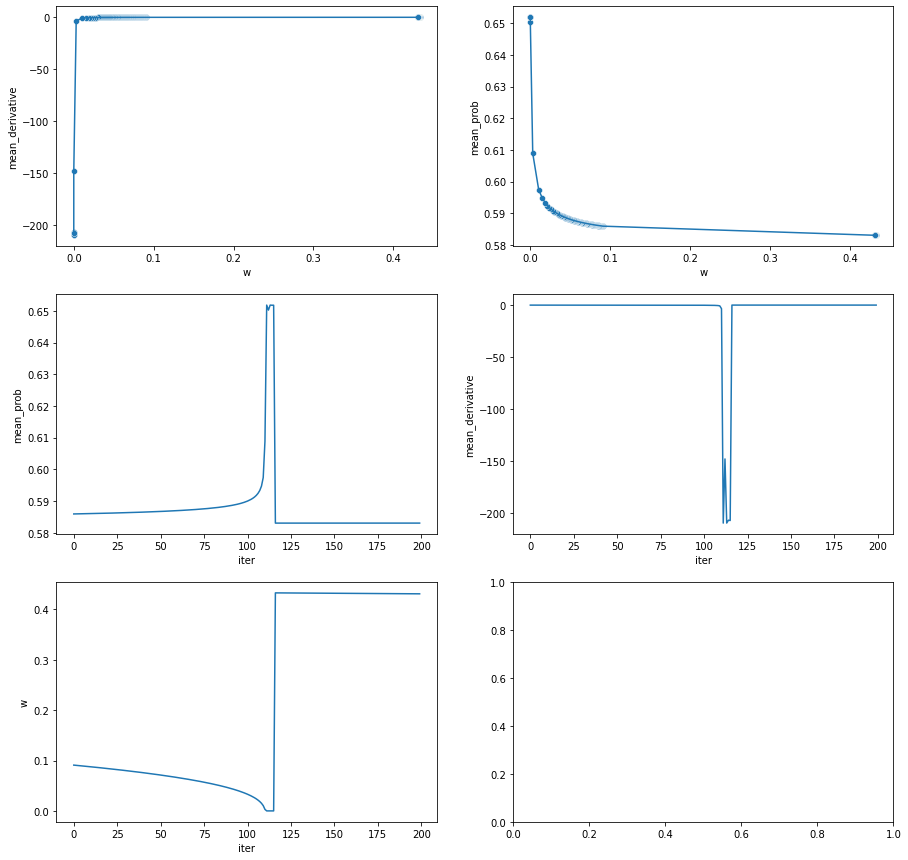

<ipython-input-4-cc25f33bd8bd>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 2.414626295622802e-12
Number of kept categories: 29
Mean target probability:  0.63628663029535
Mean target log probability:  -0.8896520271817767
STATS:                precision    recall  f1-score   support

           0       0.76      0.96      0.85     14199
           1       0.57      0.16      0.25      2488
           2       0.54      0.16      0.25      2568

    accuracy                           0.75     19255
   macro avg       0.63      0.43      0.45     19255
weighted avg       0.71      0.75      0.69     19255



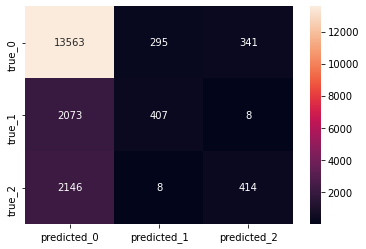

In [7]:
hs, results = experiment(train, test, 200)
show_learning_process(hs)  
show_stats(hs, results)

## Different threshold on train/test dataset

In [50]:
all_stats = []
w_tests_stats = []
w_values = [0, 0.0001, 0.005, 1e-5, 1e-12]

In [51]:
train_category_counts

array([83628, 39896, 17375,  4840,  4628,  4411,  3105,  2757,  2187,
        1578,  1370,  1048,   888,   712,   667,   595,   424,   384,
         247,   244,   225,   189,   167,   164,   147,   118,   114,
         108,   100,    98,    94,    80,    77,    64,    52,    50,
          49,    43,    41,    38,    28,    27,    19,    16,    16,
          16,    15,    15,    13,    13,    12,    12,    11,    11,
           8,     8,     7,     7,     6,     5,     5,     4,     4,
           3,     2,     2,     1,     1])

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.031892351145638105, 'mean_derivative': -0.16432891134869587, 'mean_prob': 0.5906895501902335}
199 {'iter': 199, 'w': 0.04645974187576254, 'mean_derivative': -0.09490108823540203, 'mean_prob': 0.5888757460255019}


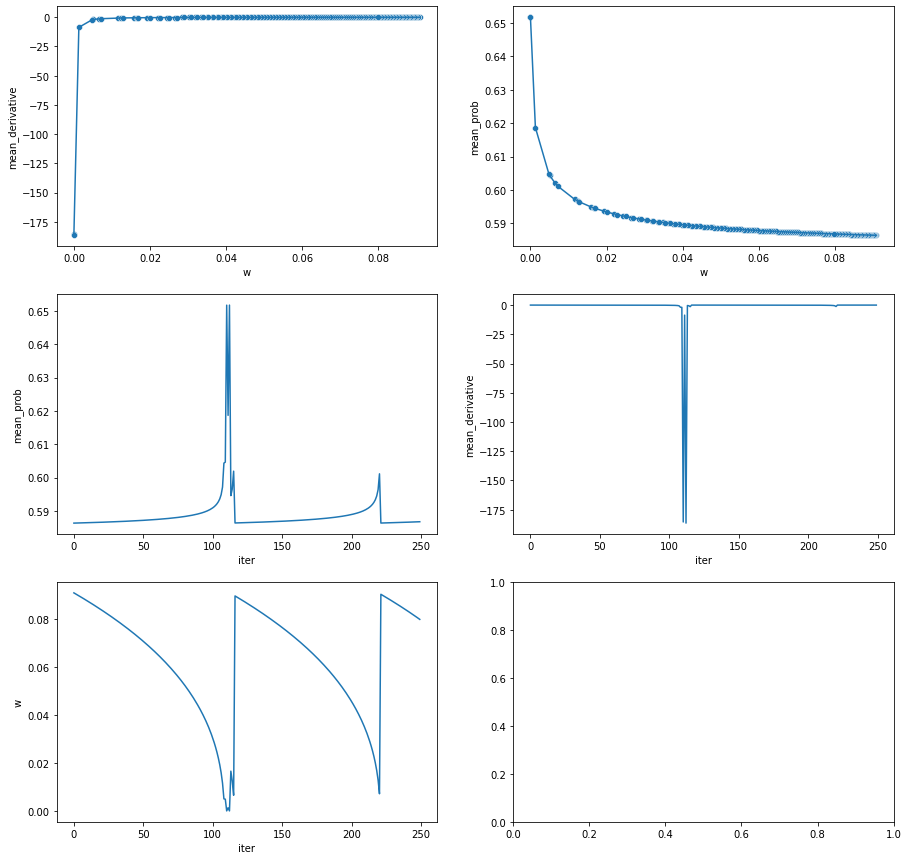

<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 4.973098695270858e-07
Number of kept categories: 54
Mean target probability:  0.6362348601040642
Mean target log probability:  -0.7200869423823535
STATS:                precision    recall  f1-score   support

           0       0.76      0.96      0.85     14199
           1       0.57      0.16      0.25      2488
           2       0.54      0.16      0.25      2568

    accuracy                           0.75     19255
   macro avg       0.63      0.43      0.45     19255
weighted avg       0.71      0.75      0.69     19255



<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


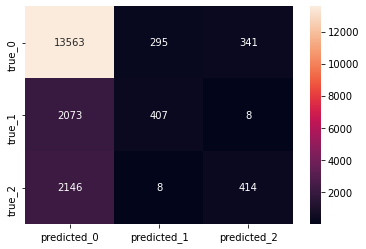

In [52]:
hs, results = experiment(train, test, treshold=10)
show_learning_process(hs)  
show_stats(hs, results, all_stats)
test_w(hs, test, w_values,w_tests_stats)

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.032147581273314234, 'mean_derivative': -0.16234375702302928, 'mean_prob': 0.5905334591592488}
199 {'iter': 199, 'w': 0.10475365143101566, 'mean_derivative': -0.02685657201615758, 'mean_prob': 0.5858519942860517}


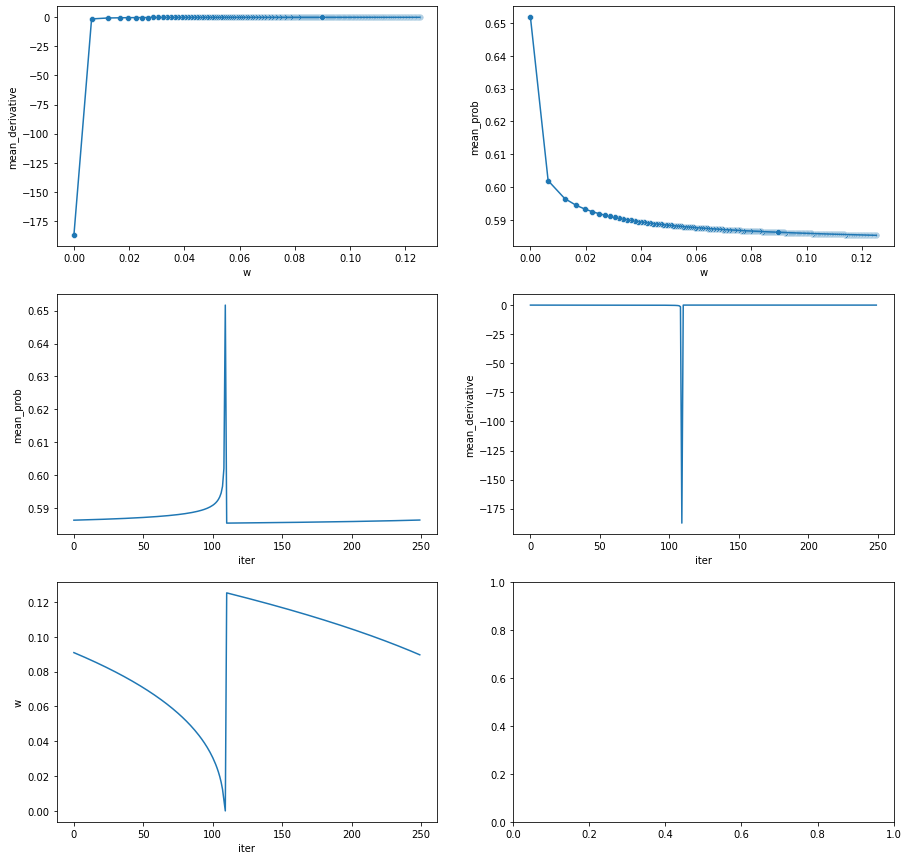

<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 8.0918980111864e-07
Number of kept categories: 42
Mean target probability:  0.6362027623850993
Mean target log probability:  -0.7134069411193862
STATS:                precision    recall  f1-score   support

           0       0.76      0.96      0.85     14199
           1       0.57      0.16      0.25      2488
           2       0.54      0.16      0.25      2568

    accuracy                           0.75     19255
   macro avg       0.63      0.43      0.45     19255
weighted avg       0.71      0.75      0.69     19255



<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


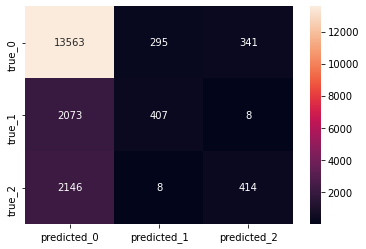

In [53]:
hs, results = experiment(train, test, treshold=20)
show_learning_process(hs)  
show_stats(hs, results, all_stats)
test_w(hs, test, w_values,w_tests_stats)

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.03275261342493375, 'mean_derivative': -0.15772751736627164, 'mean_prob': 0.5903443106662645}
199 {'iter': 199, 'w': 0.045133058785713026, 'mean_derivative': -0.09869046772494659, 'mean_prob': 0.5888029323582931}


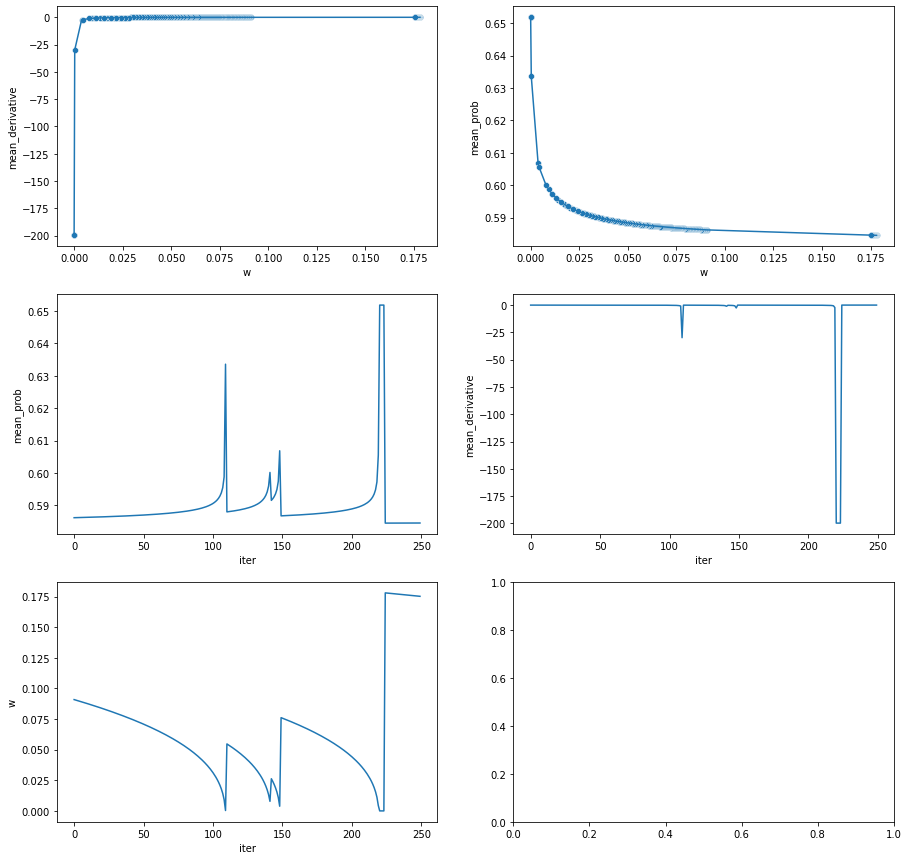

<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 6.4240215414037536e-24
Number of kept categories: 36
Mean target probability:  0.6362866305485341
Mean target log probability:  -1.2592683561198608
STATS:                precision    recall  f1-score   support

           0       0.76      0.96      0.85     14199
           1       0.57      0.16      0.25      2488
           2       0.54      0.16      0.25      2568

    accuracy                           0.75     19255
   macro avg       0.63      0.43      0.45     19255
weighted avg       0.71      0.75      0.69     19255



<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


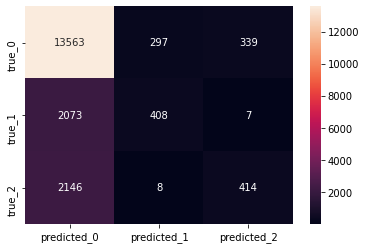

In [54]:
hs, results = experiment(train, test, treshold=50)
show_learning_process(hs)  
show_stats(hs, results, all_stats)
test_w(hs, test, w_values,w_tests_stats)

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.03447442592925875, 'mean_derivative': -0.14542944885865097, 'mean_prob': 0.5897830369575227}
199 {'iter': 199, 'w': 0.26438483924512146, 'mean_derivative': -0.005444303155710602, 'mean_prob': 0.5836260801310145}


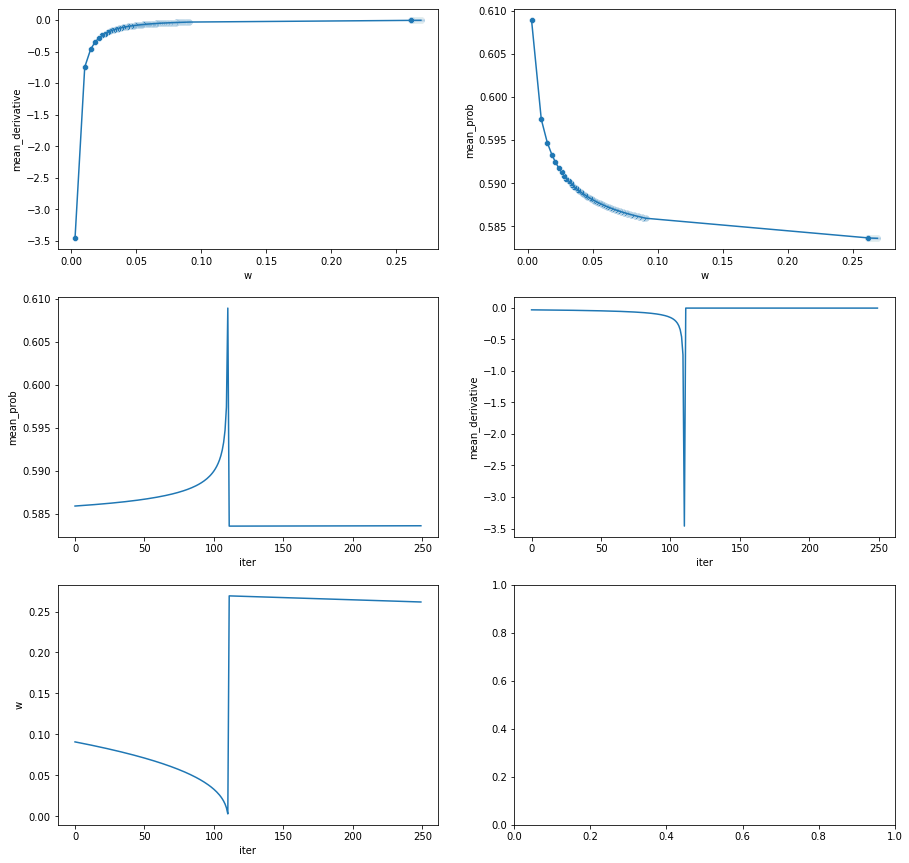

<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 0.003026905351810151
Number of kept categories: 29
Mean target probability:  0.6040565663484423
Mean target log probability:  -0.6877944495709697
STATS:                precision    recall  f1-score   support

           0       0.74      0.99      0.85     14199
           1       0.63      0.04      0.07      2488
           2       0.57      0.01      0.02      2568

    accuracy                           0.74     19255
   macro avg       0.65      0.35      0.31     19255
weighted avg       0.70      0.74      0.64     19255



<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


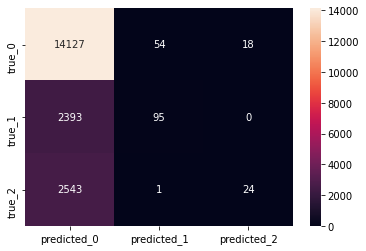

In [55]:
hs, results = experiment(train, test, treshold=100)
show_learning_process(hs)  
show_stats(hs, results, all_stats)
test_w(hs, test, w_values,w_tests_stats)

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.038820579006303084, 'mean_derivative': -0.11937837274831824, 'mean_prob': 0.5887739380580331}
199 {'iter': 199, 'w': 0.9951424419360445, 'mean_derivative': -0.0004341379706247552, 'mean_prob': 0.5823298042917217}


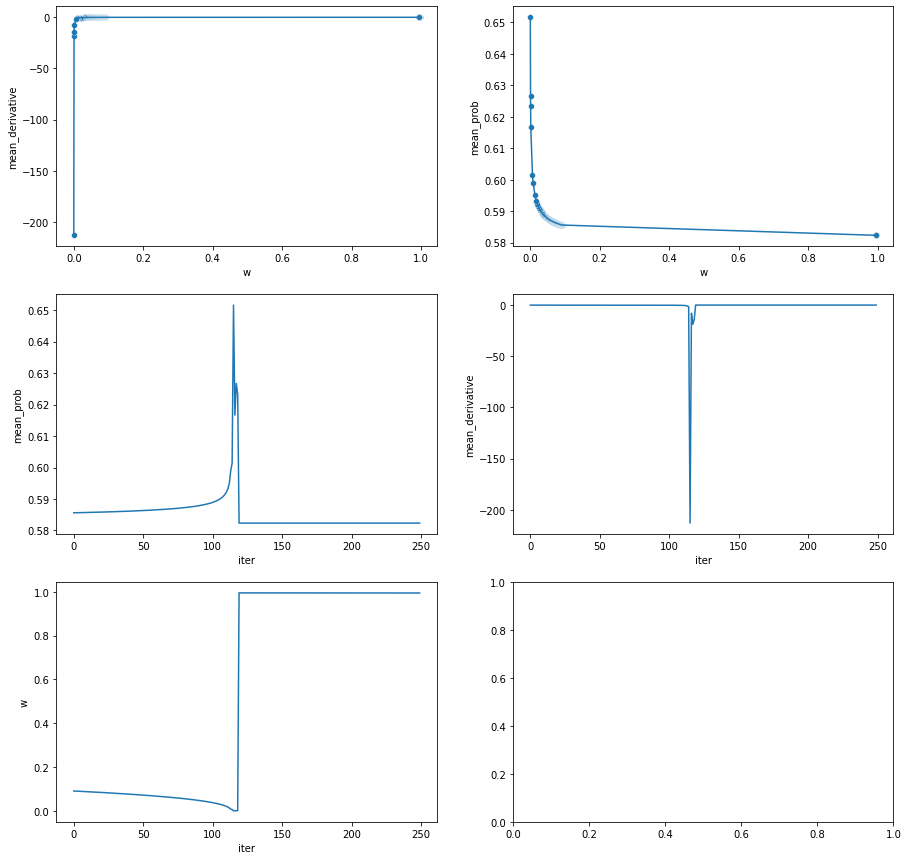

<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 1.0396850614615742e-06
Number of kept categories: 21
Mean target probability:  0.6361792156783557
Mean target log probability:  -0.7099831573748637
STATS:                precision    recall  f1-score   support

           0       0.76      0.96      0.85     14199
           1       0.57      0.16      0.25      2488
           2       0.54      0.16      0.25      2568

    accuracy                           0.75     19255
   macro avg       0.63      0.43      0.45     19255
weighted avg       0.71      0.75      0.69     19255



<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


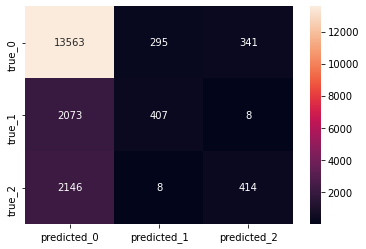

In [56]:
hs, results = experiment(train, test, treshold=200)
show_learning_process(hs)  
show_stats(hs, results, all_stats)
test_w(hs, test, w_values,w_tests_stats)

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.04520783971150107, 'mean_derivative': -0.08987977830995318, 'mean_prob': 0.5876891522237533}
199 {'iter': 199, 'w': 0.03698839568555225, 'mean_derivative': -0.12182377346858705, 'mean_prob': 0.5885486239933369}


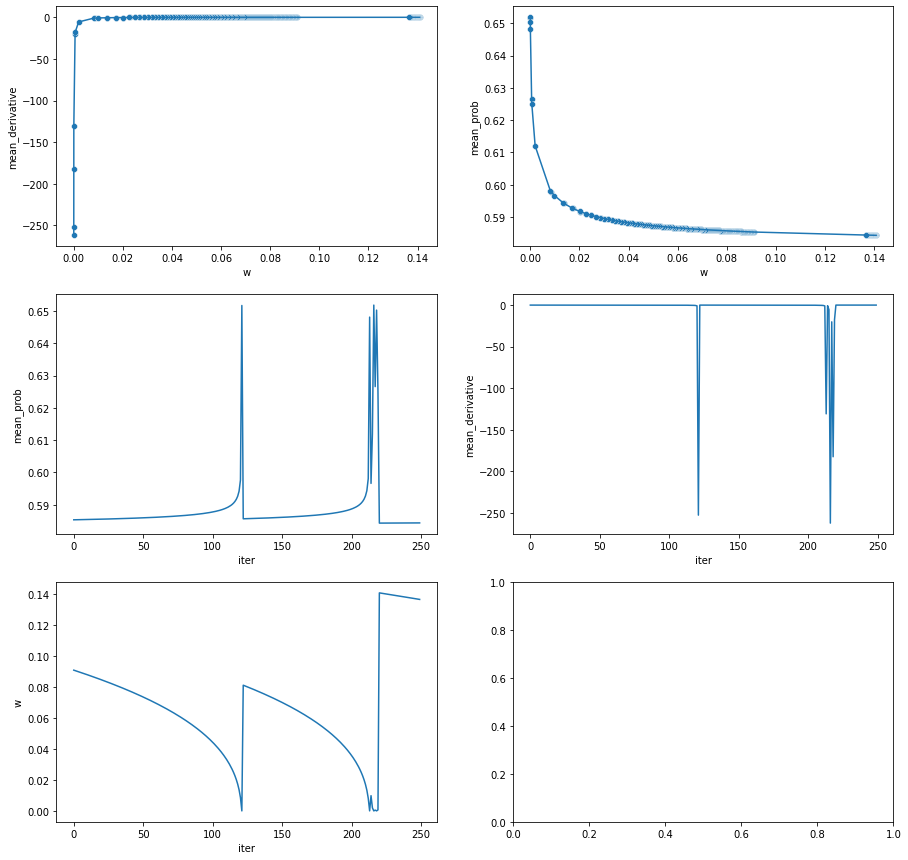

<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 2.421389230962761e-16
Number of kept categories: 16
Mean target probability:  0.6362866305485086
Mean target log probability:  -1.0173419505492125
STATS:                precision    recall  f1-score   support

           0       0.76      0.96      0.85     14199
           1       0.57      0.16      0.25      2488
           2       0.54      0.16      0.25      2568

    accuracy                           0.75     19255
   macro avg       0.63      0.43      0.45     19255
weighted avg       0.71      0.75      0.69     19255



<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


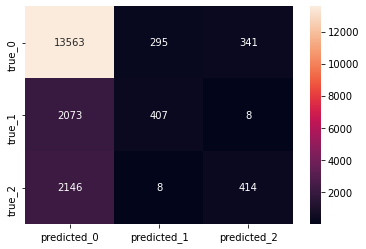

In [57]:
hs, results = experiment(train, test, treshold=500)
show_learning_process(hs)  
show_stats(hs, results, all_stats)
test_w(hs, test, w_values,w_tests_stats)

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.05180181795335111, 'mean_derivative': -0.06718115665684897, 'mean_prob': 0.5865870145592802}
199 {'iter': 199, 'w': 0.5350804529105345, 'mean_derivative': -0.001147723287205456, 'mean_prob': 0.5824934146185508}


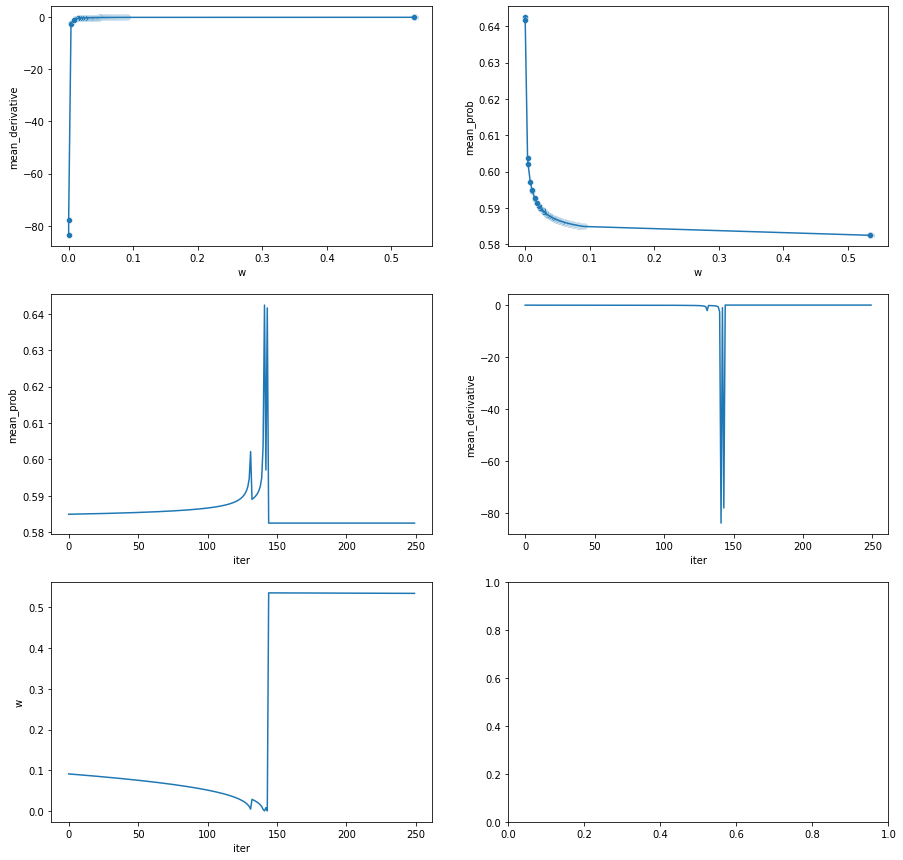

<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 6.962089425863973e-05
Number of kept categories: 12
Mean target probability:  0.6315024761864841
Mean target log probability:  -0.6613904967773727
STATS:                precision    recall  f1-score   support

           0       0.76      0.96      0.85     14199
           1       0.59      0.14      0.23      2488
           2       0.55      0.14      0.23      2568

    accuracy                           0.75     19255
   macro avg       0.63      0.42      0.44     19255
weighted avg       0.71      0.75      0.69     19255



<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


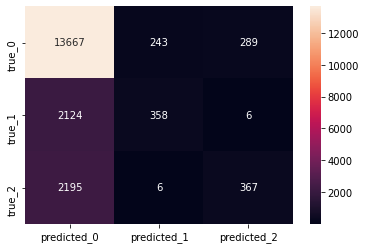

In [58]:
hs, results = experiment(train, test, treshold=1000)
show_learning_process(hs)  
show_stats(hs, results, all_stats)
test_w(hs, test, w_values,w_tests_stats)

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.06061129369003868, 'mean_derivative': -0.044389455656880704, 'mean_prob': 0.5858247530073967}
199 {'iter': 199, 'w': 0.3926768735105771, 'mean_derivative': -0.0017229472888125067, 'mean_prob': 0.5829843066430075}


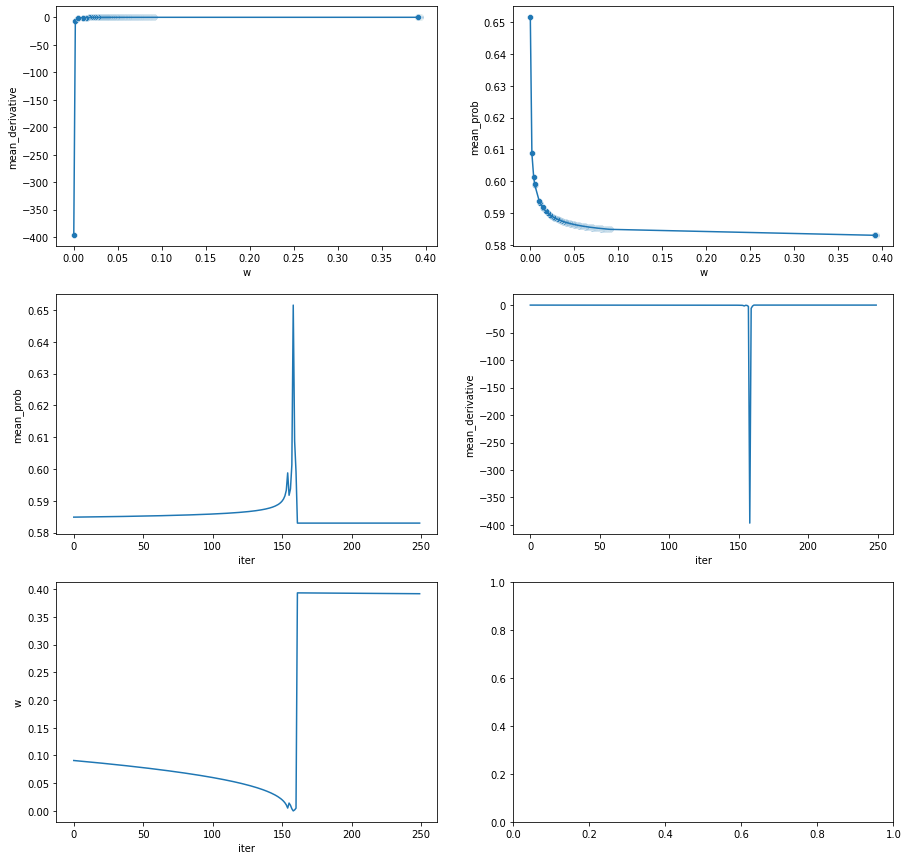

<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 6.746996168759897e-07
Number of kept categories: 7
Mean target probability:  0.636216569774018
Mean target log probability:  -0.7158970656111941
STATS:                precision    recall  f1-score   support

           0       0.76      0.96      0.85     14199
           1       0.57      0.16      0.25      2488
           2       0.54      0.16      0.25      2568

    accuracy                           0.75     19255
   macro avg       0.63      0.43      0.45     19255
weighted avg       0.71      0.75      0.69     19255



<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


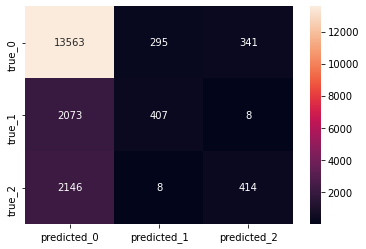

In [59]:
hs, results = experiment(train, test, treshold=3000)
show_learning_process(hs)  
show_stats(hs, results, all_stats)
test_w(hs, test, w_values,w_tests_stats)

Starting w = 0.09090909090909091
Initializing model... Model initiated
Trainset prepared
99 {'iter': 99, 'w': 0.07029166401846845, 'mean_derivative': -0.02637553217903475, 'mean_prob': 0.5849765153469341}
199 {'iter': 199, 'w': 0.017196511116243658, 'mean_derivative': -0.24319959673091002, 'mean_prob': 0.5890860306998801}


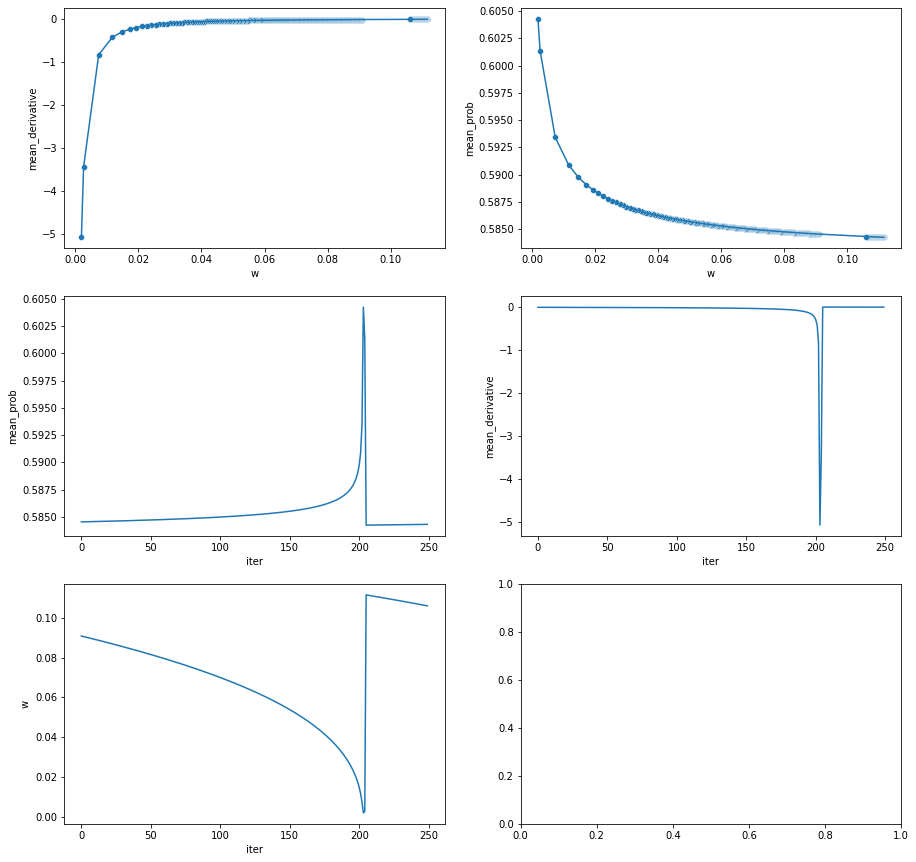

<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


w: 0.0019224437265913702
Number of kept categories: 3
Mean target probability:  0.6079162975368516
Mean target log probability:  -0.6800413165075168
STATS:                precision    recall  f1-score   support

           0       0.74      0.99      0.85     14199
           1       0.65      0.07      0.12      2488
           2       0.55      0.01      0.02      2568

    accuracy                           0.74     19255
   macro avg       0.65      0.36      0.33     19255
weighted avg       0.71      0.74      0.65     19255



<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()
<ipython-input-4-24d95af058a0>:6: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).replace({-np.inf: np.nan}).mean()


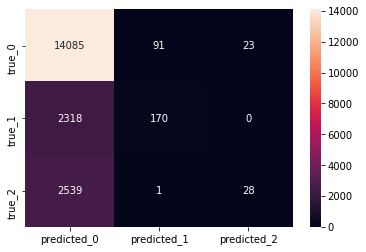

In [60]:
hs, results = experiment(train, test, treshold=10000)
show_learning_process(hs)  
show_stats(hs, results, all_stats)
test_w(hs, test, w_values, w_tests_stats)

In [63]:
w_tests_stats_df = pd.DataFrame(w_tests_stats)
w_tests_stats_df.sort_values("Mean_target_prob", ascending=False)

,w,N_of_kept_categories,Mean_target_prob,Mean_target_logprob,treshold,sklearn_stats
0,0.000000e+00,54,0.636287,-0.609855,10,"{'0': {'precision': 0.7627375998200427, 'recal..."
15,0.000000e+00,29,0.636287,-0.609855,100,"{'0': {'precision': 0.7627375998200427, 'recal..."
40,0.000000e+00,3,0.636287,-0.609855,10000,"{'0': {'precision': 0.7627375998200427, 'recal..."
35,0.000000e+00,7,0.636287,-0.609855,3000,"{'0': {'precision': 0.7627375998200427, 'recal..."
5,0.000000e+00,42,0.636287,-0.609855,20,"{'0': {'precision': 0.7627375998200427, 'recal..."
30,0.000000e+00,12,0.636287,-0.609855,1000,"{'0': {'precision': 0.7627375998200427, 'recal..."
25,0.000000e+00,16,0.636287,-0.609855,500,"{'0': {'precision': 0.7627375998200427, 'recal..."
10,0.000000e+00,36,0.636287,-0.609855,50,"{'0': {'precision': 0.7627375998200427, 'recal..."
20,0.000000e+00,21,0.636287,-0.609855,200,"{'0': {'precision': 0.7627375998200427, 'recal..."
39,1.000000e-12,7,0.636287,-0.901877,3000,"{'0': {'precision': 0.7627375998200427, 'recal..."


### Corelation check

In [301]:
#corr_df = pd.DataFrame(df, columns=["category", "result"])
corrMatrix = pd.crosstab(index=hs.train["category"], columns=df["result"])
corrMatrix

result,0,1,2
category,,,
dress,66567,12631,13686
gown,35177,4467,4737
jacket,1681,361,362
jumpsuit,3866,646,672
maxi,2605,552,286
mini,1300,131,320
other,4921,1677,537
romper,2248,479,343
sheath,14549,1634,3133


In [303]:
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(corrMatrix)
ChiSqResult

(2621.5561596444336,
 0.0,
 24,
 array([[68529.35054845, 11918.75617002, 12435.89328154],
        [32744.07978436,  5694.91319906,  5942.00701658],
        [ 1773.65917401,   308.47820758,   321.86261841],
        [ 3824.72926708,   665.20425461,   694.06647831],
        [ 2540.22817642,   441.80135969,   460.97046389],
        [ 1291.87904063,   224.68608214,   234.43487722],
        [ 5264.16730721,   915.55408115,   955.27861164],
        [ 2265.03064235,   393.9384764 ,   411.03088125],
        [14251.24817185,  2478.60443327,  2586.14739488],
        [ 3958.27016163,   688.42994329,   718.29989509],
        [ 1129.56414118,   196.45596331,   204.9798955 ],
        [  847.72645214,   147.43821153,   153.83533634],
        [ 3638.06713271,   632.73961796,   660.19324934]]))